In [2]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import math
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns

from ProjectTools import OpenBeds

dry = False

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    nano_5mc_bed_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_5hmC_bed_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_5hmC_sub.bed'
    
    wgbs_df = OpenBeds.get_wgbs(wgbs_bed_path)
    nano_mc_df = OpenBeds.get_nanopore_5mc(nano_5mc_bed_path)

    tab_df = OpenBeds.get_tab(tab_bed_path)
    nano_hmc_df = OpenBeds.get_nanopore_5hmc(nano_5hmC_bed_path)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    nano_5mc_bed_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_5hmC_bed_path = './data/prom_R10.4.1_E8.2_WGS_brain_5hmC.bed'

    wgbs_df = OpenBeds.get_wgbs(wgbs_bed_path)
    nano_mc_df = OpenBeds.get_nanopore_5mc(nano_5mc_bed_path)
    tab_df = OpenBeds.get_tab(tab_bed_path)
    nano_hmc_df = OpenBeds.get_nanopore_5hmc(nano_5hmC_bed_path)

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    return df

ecdf_df = pd.concat([filter_on_depth(wgbs_df), 
filter_on_depth(nano_mc_df), 
filter_on_depth(tab_df), 
filter_on_depth(nano_hmc_df)], 
ignore_index=True)

merged_5mc_df = pd.merge(filter_on_depth(wgbs_df), filter_on_depth(nano_mc_df), on=["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_Nano"]).reset_index()
merged_5hmc_df = pd.merge(filter_on_depth(tab_df), filter_on_depth(nano_hmc_df), on=["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_Nano"]).reset_index()

merged_5mc_df["WGBS_bin"] = pd.cut(merged_5mc_df["percentMeth_WGBS"], 20)
merged_5hmc_df["TAB_bin"] = pd.cut(merged_5hmc_df["percentMeth_TAB"], 20)

mc_lineplot_df = pd.DataFrame(merged_5mc_df.groupby("WGBS_bin").median(numeric_only=True)["percentMeth_Nano"])
hmc_lineplot_df = pd.DataFrame(merged_5hmc_df.groupby("TAB_bin").median(numeric_only=True)["percentMeth_Nano"])


merged_5mc_df["binarised"] = preprocessing.binarize(merged_5mc_df[["percentMeth_WGBS"]], threshold=50.0)
merged_5hmc_df["binarised"] = preprocessing.binarize(merged_5hmc_df[["percentMeth_TAB"]], threshold=40.0)   

mc_fpr, mc_tpr, mc_threshold = metrics.roc_curve(merged_5mc_df["binarised"], merged_5mc_df["percentMeth_Nano"])
hmc_fpr, hmc_tpr, hmc_threshold = metrics.roc_curve(merged_5hmc_df["binarised"], merged_5hmc_df["percentMeth_Nano"])

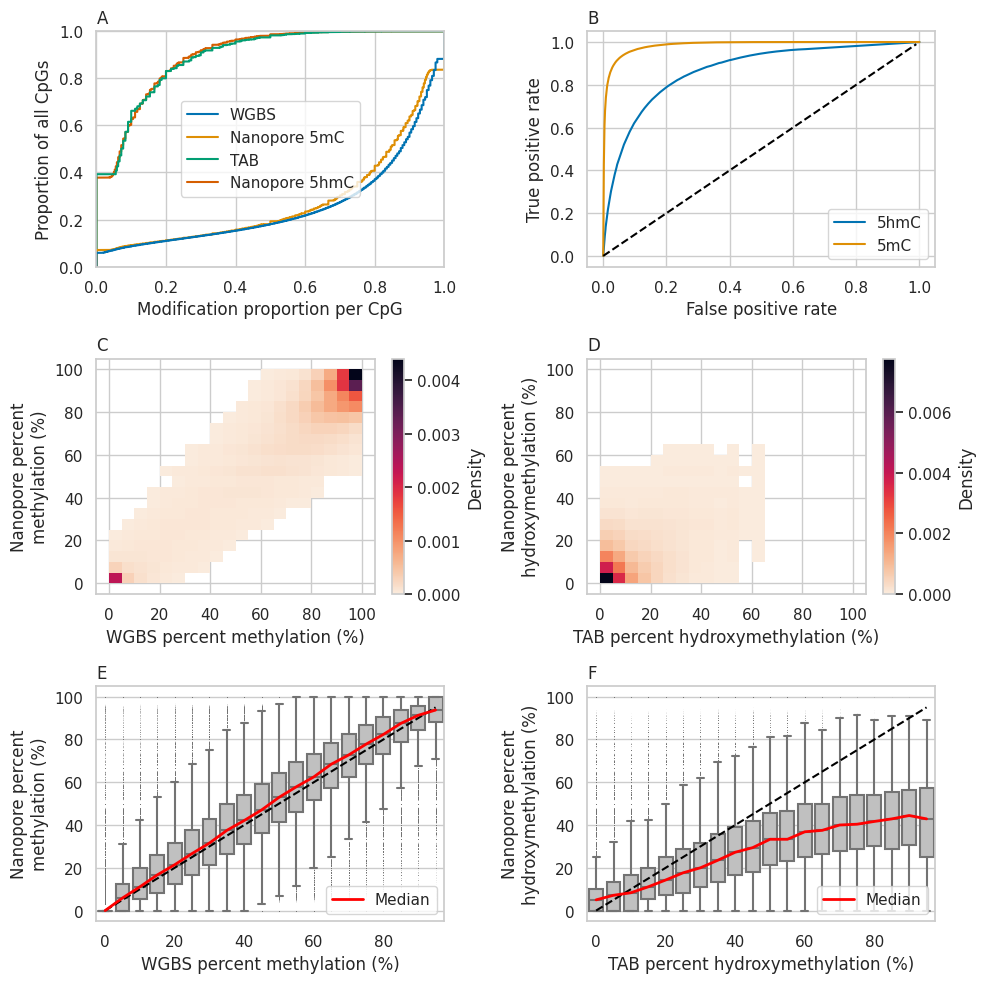

In [3]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = pl.figure(figsize=(10, 10)) 
gs = fig2.add_gridspec(nrows=3, ncols=2)

ax1 = fig2.add_subplot(gs[0, 0])
ax2 = fig2.add_subplot(gs[0, 1])
ax3 = fig2.add_subplot(gs[1, 0])
ax4 = fig2.add_subplot(gs[1, 1])
ax5 = fig2.add_subplot(gs[2, 0])
ax6 = fig2.add_subplot(gs[2, 1])

sns.ecdfplot(ecdf_df, x="percentMeth", hue="method", ax=ax1, )
sns.move_legend(ax1, "center", title=None)
ax1.set_ylabel("Proportion of all CpGs")
ax1.set_xlabel("Modification proportion per CpG")
ax1.set_xticks(np.arange(0, 120, 20), labels=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"])
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

ax2.plot(hmc_fpr, hmc_tpr, '-', label="5hmC")
ax2.plot(mc_fpr, mc_tpr, '-', label="5mC")
ax2.set_xlabel("False positive rate")
ax2.set_ylabel("True positive rate")
ax2.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), "black", linestyle="--")
ax2.legend()
ax2.set_title("B", loc="left")

sns.histplot(merged_5mc_df, x="percentMeth_WGBS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax3, cbar_kws=dict(label="Density"))
ax3.set_xlabel("WGBS percent methylation (%)")
ax3.set_ylabel("Nanopore percent\nmethylation (%)")
ax3.set_title("C", loc="left")

sns.histplot(merged_5hmc_df, x="percentMeth_TAB", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax4, cbar_kws=dict(label="Density"))
ax4.set_xlabel("TAB percent hydroxymethylation (%)")
ax4.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax4.set_title("D", loc="left")

sns.boxplot(merged_5mc_df, x="WGBS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax5)
ax5.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax5.set_xticks(np.arange(0, 24, 4), labels=["0", "20", "40", "60", "80", "100"])
ax5.set_xlabel("WGBS percent methylation (%)")
ax5.set_ylabel("Nanopore percent\nmethylation (%)")
ax5.plot(np.arange(0, 20, 1), mc_lineplot_df["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax5.legend()
sns.move_legend(ax5, "lower right")
ax5.set_title("E", loc="left")

sns.boxplot(merged_5hmc_df, x="TAB_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax6)
ax6.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax6.set_xticks(np.arange(0, 24, 4), labels=["0", "20", "40", "60", "80", "100"])
ax6.set_xlabel("TAB percent hydroxymethylation (%)")
ax6.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax6.plot(np.arange(0, 20, 1), hmc_lineplot_df["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax6.legend()
sns.move_legend(ax6, "lower right")
ax6.set_title("F", loc="left")

fig2.tight_layout()